In [150]:

import numpy as np
from matplotlib import pyplot as plt
from tslearn.clustering import TimeSeriesKMeans
from tslearn.preprocessing import TimeSeriesScalerMeanVariance, TimeSeriesResampler
from tslearn.utils import to_time_series_dataset


In [151]:
# Data is in lines of the text file
# Each line is timeseries
# Each timeseries is comma separated

def load_data(f: str, line_limit=None) -> np.ndarray:
    """
    Loads data from a text file
    """
    data = []
    with open(f, 'r') as file:
        for line in file:
            data.append([float(x) for x in line.split(',')])
            if line_limit is not None and len(data) == line_limit:
                break
    return np.array(data)

cubic_f = 'data/cubic.txt'
new_reno_f = 'data/new_reno.txt'

rows = 50

cubic_data = load_data(cubic_f, line_limit=rows)
new_reno_data = load_data(new_reno_f, line_limit=rows)

# Break off 10% of the data for testing
test_size = int(len(cubic_data) * 0.1)
cubic_test = cubic_data[:test_size]
cubic_data = cubic_data[test_size:]

test_size = int(len(new_reno_data) * 0.1)
new_reno_test = new_reno_data[:test_size]
new_reno_data = new_reno_data[test_size:]

print(f'Cubic data shape: {cubic_data.shape}')
print(f'New Reno data shape: {new_reno_data.shape}')

print(f'Cubic test shape: {cubic_test.shape}')
print(f'New Reno test shape: {new_reno_test.shape}')

X_AXIS = np.arange(0, 60, 0.1)

       

Cubic data shape: (45, 600)
New Reno data shape: (45, 600)
Cubic test shape: (5, 600)
New Reno test shape: (5, 600)


In [152]:
def segment_data(data: np.ndarray) -> list:
    """
    In each flow, there will be many periodic events.
    Each segment is differentiated by a negative gradient.

    Returns a list of segments, computed from all the flows in data
    """

    segments = []
    for flow in data:
        segment = []
        for i in range(1, len(flow)):
            if flow[i] < flow[i-1]:
                segments.append(segment)
                segment = []
            segment.append(flow[i])
        segments.append(segment)
    return segments


cubic_segments = segment_data(cubic_data)
new_reno_segments = segment_data(new_reno_data)

print('Before filtering and balancing between training classes:')

num_cubic_flows = len(cubic_data)
num_new_reno_flows = len(new_reno_data)

print(f'Number of cubic flows: {num_cubic_flows}')
print(f'Number of new reno flows: {num_new_reno_flows}')

num_cubic_segments = len(cubic_segments)
num_new_reno_segments = len(new_reno_segments)

print(f'Number of cubic segments: {num_cubic_segments}')
print(f'Number of new reno segments: {num_new_reno_segments}')

print(f'Average cubic segment length: {num_cubic_segments / num_cubic_flows}')
print(f'Average new reno segment length: {num_new_reno_segments / num_new_reno_flows}')

SEGMENT_MIN_LEN = 10
SEGMENT_MAX_LEN = 100

# Filter out segments that are too short or too long
cubic_segments = [segment for segment in cubic_segments if SEGMENT_MIN_LEN <= len(segment) <= SEGMENT_MAX_LEN]
new_reno_segments = [segment for segment in new_reno_segments if SEGMENT_MIN_LEN <= len(segment) <= SEGMENT_MAX_LEN]

# Trim it so both have the same number of segments
min_len = min(len(cubic_segments), len(new_reno_segments))
cubic_segments = cubic_segments[:min_len]
new_reno_segments = new_reno_segments[:min_len]

Before filtering and balancing between training classes:
Number of cubic flows: 45
Number of new reno flows: 45
Number of cubic segments: 935
Number of new reno segments: 537
Average cubic segment length: 20.77777777777778
Average new reno segment length: 11.933333333333334


First sample cubic segments: 18
First sample new reno segments: 13


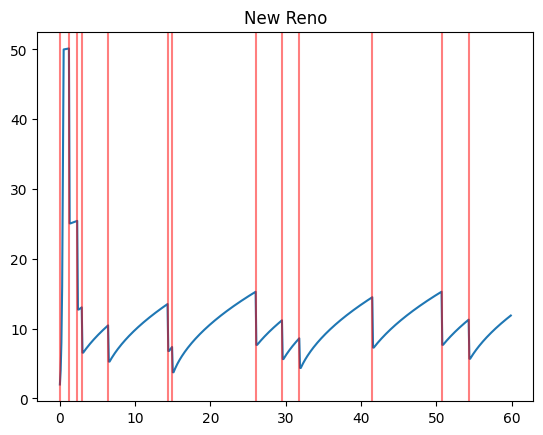

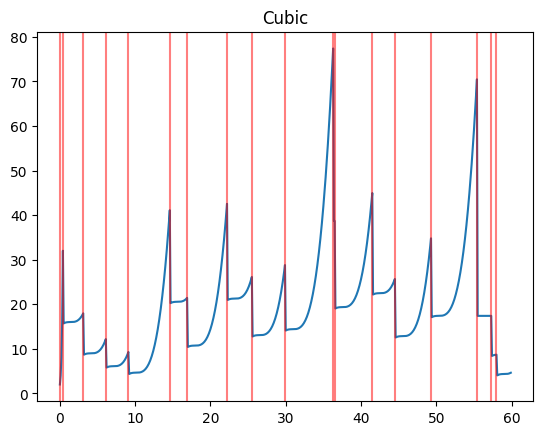

In [153]:
# For demo, plot the first flow of each and show the segments with vertical lines
# Use the segment function for this

first_sample_cubic = cubic_data[0]
first_sample_new_reno = new_reno_data[0]

# Segment the first sample of each
first_cubic_segments = segment_data(np.array([first_sample_cubic]))
first_new_reno_segments = segment_data(np.array([first_sample_new_reno]))

print(f'First sample cubic segments: {len(first_cubic_segments)}')
print(f'First sample new reno segments: {len(first_new_reno_segments)}')


plt.plot(X_AXIS, first_sample_new_reno, label='New Reno Segmentation')

iter_total = 0
for segment in first_new_reno_segments:
    plt.axvline(x=X_AXIS[iter_total], color='r', alpha=0.5)
    iter_total += len(segment)

plt.title('New Reno')
plt.show()

plt.plot(X_AXIS, first_sample_cubic, label='Cubic Segmentation')

iter_total = 0
for segment in first_cubic_segments:
    plt.axvline(x=X_AXIS[iter_total], color='r', alpha=0.5)
    iter_total += len(segment)

plt.title('Cubic')
plt.show()




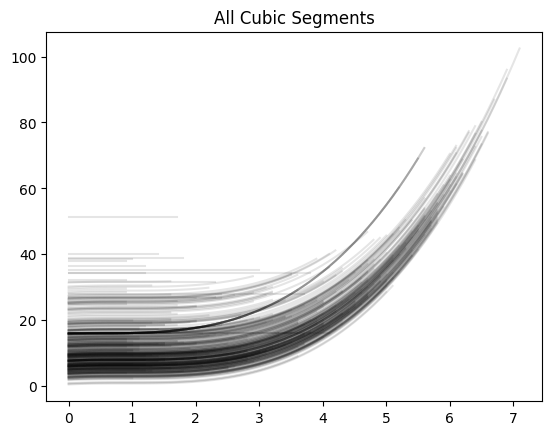

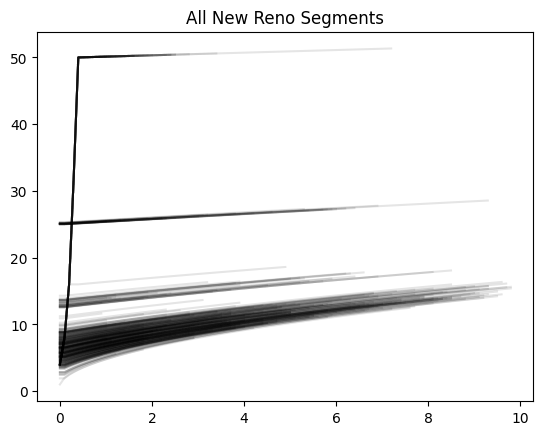

In [154]:
for segment in cubic_segments:
    plt.plot(X_AXIS[:len(segment)], segment, color='black', alpha=0.1)

plt.title('All Cubic Segments')
plt.show()

for segment in new_reno_segments:
    plt.plot(X_AXIS[:len(segment)], segment, color='black', alpha=0.1)

plt.title('All New Reno Segments')
plt.show()

In [155]:
def cluster(data, num_clusters=2):
    km = TimeSeriesKMeans(n_clusters=num_clusters, metric="dtw", verbose=True, random_state=0)
    km.fit(data)
    return km

Cubic segment count: 394
New Reno segment count: 394
Combined segment count: 788
Average segment length: 40.06979695431472
Standard deviation of segment lengths: 21.242770079945608
Max length: 99 (9.9 seconds)
Number of segments: 788
Resampled data shape: (414, 99, 1)


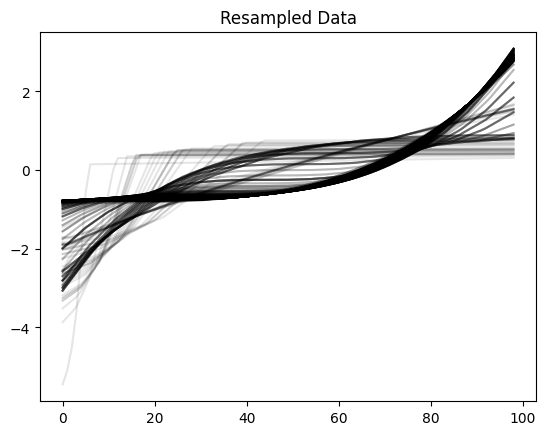

[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 799 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 799 tasks      | elapsed:    0.0s


1.369 --> 

[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 799 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.0s


0.575 --> 0.575 --> 

[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 799 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 799 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 799 tasks      | elapsed:    0.0s


0.575 --> 0.575 --> 

[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 799 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:    0.0s


0.574 --> 0.574 --> 

[Parallel(n_jobs=1)]: Done 799 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 799 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 799 tasks      | elapsed:    0.0s


0.574 --> 0.574 --> 

[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 799 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s


0.574 --> 0.574 --> 

[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 799 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 799 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:    0.0s


0.574 --> 0.574 --> 

[Parallel(n_jobs=1)]: Done 799 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 799 tasks      | elapsed:    0.0s


0.574 --> 

[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 799 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:    0.0s


0.574 --> 0.574 --> 

[Parallel(n_jobs=1)]: Done 799 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 799 tasks      | elapsed:    0.0s


0.574 --> 

[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 799 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.0s


0.574 --> 0.574 --> 

[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 799 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 799 tasks      | elapsed:    0.0s


0.574 --> 

[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 799 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.0s


0.574 --> 0.574 --> 

[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 799 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 799 tasks      | elapsed:    0.0s


0.574 --> 

[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 799 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.0s


0.574 --> 0.574 --> 

[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 799 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 799 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s


0.574 --> 

[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 799 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:    0.0s


0.574 --> 0.574 --> 

[Parallel(n_jobs=1)]: Done 799 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 799 tasks      | elapsed:    0.0s


0.573 --> 

[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 799 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.0s


0.573 --> 0.573 --> 

[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 799 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 799 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.0s


0.573 --> 

[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 799 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.0s


0.573 --> 

[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 799 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.0s


0.573 --> 

[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 799 tasks      | elapsed:    0.0s


0.573 --> 

[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 799 tasks      | elapsed:    0.0s


0.573 --> 

[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 799 tasks      | elapsed:    0.0s


0.573 --> 

[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 799 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s


0.573 --> 0.573 --> 

[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 799 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 799 tasks      | elapsed:    0.0s


0.573 --> 0.573 --> 

[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 799 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 799 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:    0.0s


0.573 --> 

[Parallel(n_jobs=1)]: Done 799 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 799 tasks      | elapsed:    0.0s


0.573 --> 0.573 --> 


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 799 tasks      | elapsed:    0.0s


In [156]:
# Combine the segments from both flows
# Recall that they are list of np arrays, which can be of different lengths
combined_data = cubic_segments + new_reno_segments
print(f'Cubic segment count: {len(cubic_segments)}')
print(f'New Reno segment count: {len(new_reno_segments)}')
print(f'Combined segment count: {len(combined_data)}')

combibed_data = np.random.shuffle(combined_data)

segment_lengths = [len(segment) for segment in combined_data]

# Find average and standard deviation of segment lengths
avg_len = np.mean(segment_lengths)
std_len = np.std(segment_lengths)
print(f'Average segment length: {avg_len}')
print(f'Standard deviation of segment lengths: {std_len}')


# Ensure all segments have the same length using padding/resampling
max_length = max(len(segment) for segment in combined_data)  # Find the longest segment
print(f'Max length: {max_length} ({max_length/10} seconds)')
print(f'Number of segments: {len(combined_data)}')
resampled_data = [
    TimeSeriesResampler(sz=max_length).fit_transform([segment])[0] 
    for segment in combined_data
]

# Convert to a time-series dataset and scale
X = to_time_series_dataset(resampled_data)
scaler = TimeSeriesScalerMeanVariance(mu=0., std=1.)  # Rescale time series
X = scaler.fit_transform(X)

# Prune out the segments that are not strictly increasing
X = np.array([segment for segment in X if np.all(np.diff(segment.squeeze()) > 0)])

# Resampled data shape
print(f'Resampled data shape: {X.shape}')

# Plot the resampled data
for segment in X:
    plt.plot(segment, color='black', alpha=0.1)

plt.title('Resampled Data')
plt.show()

# Perform clustering
km = cluster(X, num_clusters=2)


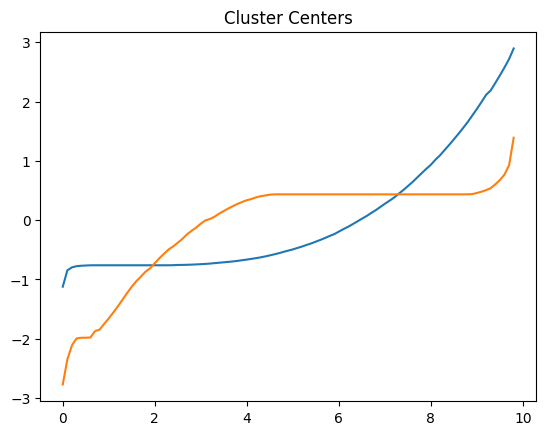

In [157]:
# Plot the cluster centers
cluster_1 = km.cluster_centers_[0].ravel()
cluster_2 = km.cluster_centers_[1].ravel()

plt.plot(X_AXIS[:len(cluster_1)], cluster_1, label='Cluster 1')
plt.plot(X_AXIS[:len(cluster_2)], cluster_2, label='Cluster 2')
plt.title('Cluster Centers')
plt.show()

Max length: 99 (9.9 seconds)
Number of segments: 110
Resampled test data shape: (67, 99, 1)


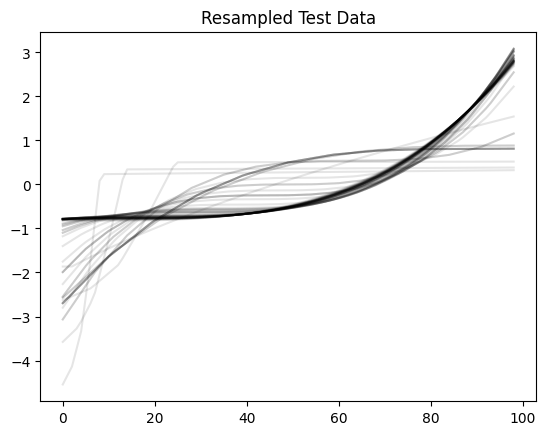

Cluster 1 count: 51
Cluster 2 count: 16


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s


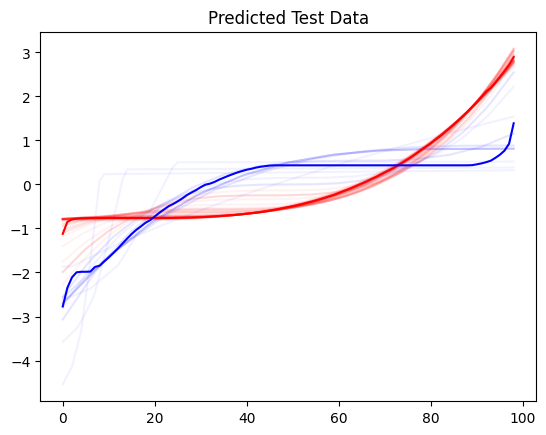

In [160]:
# Now run the test data through the model
# First, segment the test data
cubic_test_segments = segment_data(cubic_test)
new_reno_test_segments = segment_data(new_reno_test)

# Filter out segments that are too short or too long
cubic_test_segments = [segment for segment in cubic_test_segments if SEGMENT_MIN_LEN <= len(segment) <= SEGMENT_MAX_LEN]
new_reno_test_segments = [segment for segment in new_reno_test_segments if SEGMENT_MIN_LEN <= len(segment) <= SEGMENT_MAX_LEN]

# Ensure all segments have the same length using padding/resampling
max_length = max(len(segment) for segment in cubic_test_segments + new_reno_test_segments)  # Find the longest segment
print(f'Max length: {max_length} ({max_length/10} seconds)')
print(f'Number of segments: {len(cubic_test_segments) + len(new_reno_test_segments)}')
resampled_cubic_test = [
    TimeSeriesResampler(sz=max_length).fit_transform([segment])[0] 
    for segment in cubic_test_segments
]

resampled_new_reno_test = [
    TimeSeriesResampler(sz=max_length).fit_transform([segment])[0] 
    for segment in new_reno_test_segments
]

# Convert to a time-series dataset and scale
X_test = to_time_series_dataset(resampled_cubic_test + resampled_new_reno_test)
X_test = scaler.fit_transform(X_test)

# Ensure all segments start at zero by subtracting the first element
# X_test = np.array([segment - segment[0] for segment in X_test])

# Prune out the segments that are not strictly increasing, while keeping track of how many of each class
class_1_count = 0
class_2_count = 0

pruned_X_test = []
for i, segment in enumerate(X_test):
    if np.all(np.diff(segment.squeeze()) > 0):
        pruned_X_test.append(segment)
        if i < X_test.shape[0] // 2:
            class_1_count += 1
        else:
            class_2_count += 1

X_test = np.array(pruned_X_test)

Y_test = np.array([0] * class_1_count + [1] * class_2_count)

# Resampled data shape
print(f'Resampled test data shape: {X_test.shape}')

# Plot the resampled data
for segment in X_test:
    plt.plot(segment, color='black', alpha=0.1)

plt.title('Resampled Test Data')
plt.show()

# Predict the test data
y_pred = km.predict(X_test)

# Plot the test data
for i, segment in enumerate(X_test):
    if y_pred[i] == 0:
        plt.plot(segment, color='red', alpha=0.05)
    else:
        plt.plot(segment, color='blue', alpha=0.05)

cluster_1_count = np.sum(y_pred == 0)
cluster_2_count = np.sum(y_pred == 1)

print(f'Cluster 1 count: {cluster_1_count}')
print(f'Cluster 2 count: {cluster_2_count}')

# Also plot the scaled cluster centers
plt.plot(cluster_1, color='red', label='Cluster 1')
plt.plot(cluster_2, color='blue', label='Cluster 2')

plt.title('Predicted Test Data')
plt.show()



In [161]:
# Accuracy
correct = np.sum(y_pred == Y_test)
total = len(Y_test)
accuracy = correct / total

print(f'Correct: {correct}')
print(f'Total: {total}')
print(f'Accuracy: {accuracy}')

Correct: 47
Total: 67
Accuracy: 0.7014925373134329
